## PyTorch Transfer Learning

Transfer learning means reusing a well-trained model’s learned patterns (weights) on a new, similar task.


📷 Example (Vision): Use a model trained on ImageNet (millions of images) to build your own food image classifier.


📝 Example (Language): Use a language model trained on tons of text to classify new text samples.


Core Idea: Start from a model that already knows a lot — and fine-tune it for your specific problem.


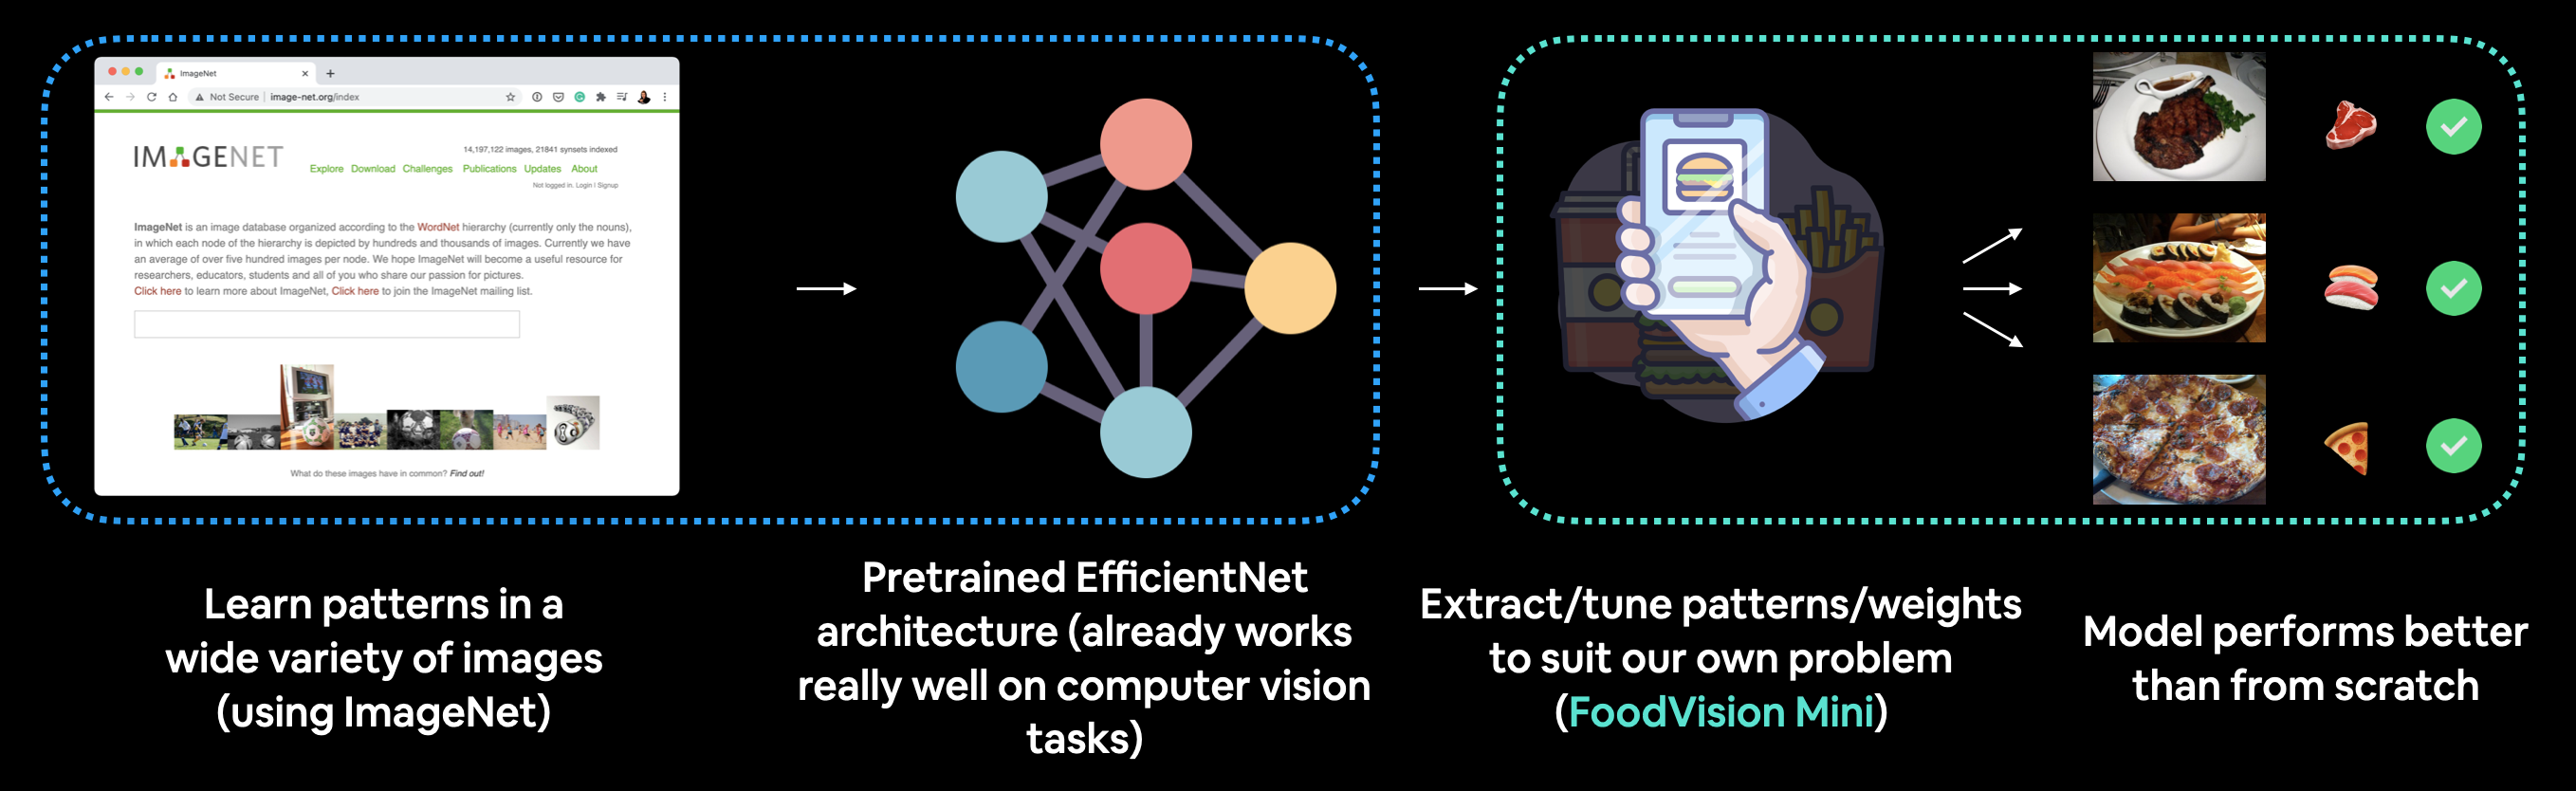

## Why Use Transfer Learning?

✅ Proven Architectures
Use models that have already shown success on similar tasks.

📉 Less Data Needed
Reuse learned patterns from large datasets to get great results with less training data.

Bottom Line: Save time, compute, and data — while achieving high performance.

# Both research and practice support the use of transfer learning too.


#### The things that really make a difference (transfer learning), if we can do better at transfer learning, it’s this world changing thing. Suddenly lots more people can do world-class work with less resources and less data. — Jeremy Howard on the Lex Fridman Podcast



### 🔍 Where to Find Pretrained Models
PyTorch Libraries – Pretrained models for vision, text, audio
→ torchvision.models, torchtext.models, etc.

HuggingFace Hub – Models for NLP, vision, audio, and more
→ huggingface.co/models

timm – Latest vision models in PyTorch
→ pytorch-image-models

Papers with Code – SOTA models + benchmarks + code
→ paperswithcode.com

# Steps we are going to Cover
🔢 Step	 | 📌 Task	  |📝 Summary
0. Setup: Download helper code |	Reuse previously written utilities
1. Get Data:	Load dataset	|  Pizza 🍕, steak 🥩, sushi 🍣 images
2. Datasets & DataLoaders:	Prepare inputs |	Use data_setup.py for loading
3. Pretrained Model:	Download & customize|	Use torchvision.models
4. Train:	    Fit the model	| Train on food dataset
5. Evaluate:	Plot loss curves	| Check for overfitting/underfitting
6. Predict:	  Test on new images |	Visualize real predictions

# Setup

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.7.1+cu126
torchvision version: 0.22.1+cu126
[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1457), reused 1401 (delta 1401), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 14.34 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## GETTING DATA
pizza steak sushi zip from the github and then unzip it.

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [ ]:
# DATA SPLITTING
train_dir = image_path / "train"
test_dir = image_path / "test"

# Create Datasets and Dataloaders

Use the existing data_setup.py from Going Modular to prepare datasets and DataLoaders.

For pretrained models from torchvision.models, apply model-specific transforms to images:

Resize/crop to expected input size (usually 224×224).

Normalize using ImageNet mean and std:

Mean: [0.485, 0.456, 0.406]

Std: [0.229, 0.224, 0.225]

These transforms ensure inputs match the pretrained model’s training conditions for best results.

# Creating a transform for torchvision.models (manual creation)

In [ ]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

# DataLoaders with Datasets

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
from torchvision import transforms

# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x799df83721d0>,
 ['pizza', 'steak', 'sushi'])